In [1]:
import warnings
warnings.filterwarnings('ignore')

import shap
from acv_explainers import ACVTree
from acv_explainers.utils import *
from experiments.exp_linear_gmm import *

In [2]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
import seaborn as sns

import random 
import numpy as np
import pandas as pd

random.seed(212)
np.random.seed(212)

# 1- DEMO CLASSIFIER

##  How to compute SDP, $S^\star$, Shapley values based on $S^\star$, Global SDP

### Load data and model

In [3]:
X = pd.read_csv('/home/samoukou/Documents/ACV/data/lucas0_train.csv')
X.head()

y = X.Lung_cancer.values
X.drop(['Lung_cancer'], axis=1, inplace=True)

num_features = X.shape[1]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

# Model 
tree = DecisionTreeClassifier(min_samples_leaf=20, random_state=212)
tree.fit(X_train, y_train)

accuracy_train = roc_auc_score(y_train, tree.predict_proba(X_train)[:, 1])
accuracy_test = roc_auc_score(y_test, tree.predict_proba(X_test)[:, 1])
print('[* TREE *]')
print('train acc = {} --- test acc = {}'.format(accuracy_train, accuracy_test))

forest = RandomForestClassifier(n_estimators=10, min_samples_leaf=2, random_state=212)
forest.fit(X_train, y_train)

accuracy_train = roc_auc_score(y_train, forest.predict_proba(X_train)[:, 1])
accuracy_test = roc_auc_score(y_test, forest.predict_proba(X_test)[:, 1])
print('[* FOREST *]')
print('train acc = {} --- test acc = {}'.format(accuracy_train, accuracy_test))

[* TREE *]
train acc = 0.9230919439227646 --- test acc = 0.9127666666666667
[* FOREST *]
train acc = 0.9416321592186097 --- test acc = 0.90515


### Build ACVTree for explanations

In [4]:
# data is always a np.array(dtype=np.double)

acvtree = ACVTree(model=forest, data=X_train.values)

### Let's choose an observation to explain

In [5]:
idx = 267
ind = X_train.values[idx]
y_ind = y_train[idx]
fx = forest.predict(np.expand_dims(ind, 0))[0]

In [6]:
X_train[idx:idx+1]

,Smoking,Yellow_Fingers,Anxiety,Peer_Pressure,Genetics,Attention_Disorder,Born_an_Even_Day,Car_Accident,Fatigue,Allergy,Coughing
1690,0,0,0,0,0,0,1,1,0,0,0


In [7]:
print('f(x) = {}, y_ind = {}'.format(fx, y_ind))

f(x) = 0, y_ind = 0


### SDP(x, f) of Smoking, Genetics ?

In [8]:
var = ['Smoking', 'Genetics', 'Coughing']
columns_names = [X.columns[i] for i in range(X.shape[1])]
id_var = [i for i in range(X.shape[1]) if X.columns[i] in var] 
data = np.array(X_train.values, dtype=np.double)

sdp = acvtree.compute_sdp_clf(X=np.expand_dims(ind, 0), S=np.array(id_var), data=data)

print('SDP(x, f) of variable = {} is {}'.format(var, sdp))

SDP(x, f) of variable = ['Smoking', 'Genetics', 'Coughing'] is [0.91325319]


In [9]:
x = np.expand_dims(ind, 0)

### Compute the active coalition $S^\star$ ?

In [10]:
global_proba = 0.9

sdp_importance, sdp_index, size, sdp =\
acvtree.importance_sdp_clf(X=x, data=data, C=[[]], global_proba=global_proba, num_threads=5)

- sdp_importance := tensor of shape: nb_observations $\times$ nb_features, it represents the global SDP of each variables across data
- sdp_index := tensor of shape: nb_observations \x nb_features, element different to -1 corresponds to the index of the variables in $S^\star$ for each observation
- size := tensor of shape: nb_observations, it corresponds to the size of the $S^\star$ for each observation
- sdp := tensor of shape: nb_observations, it is the SDP value of $S^\star$ for each observations

In [11]:
index = list(range(X.shape[1]))
sdp_cluster = [[sdp_index[0, i] for i in range(size[0])]]
sdp_cluster += [list(set(index) - set(sdp_cluster[0]))]

print('Cluster find by SDP = {}'.format(sdp_cluster[0]))

sdp_importance_cluster = []
for c in sdp_cluster:     
    sdp_importance_cluster.append(acvtree.compute_sdp_clf(x, S=np.array(c), data=data))

sdp_importance_cluster = np.array(sdp_importance_cluster).reshape(-1)

sdp_importance_name = []
for c in sdp_cluster:
    sdp_importance_name.append(str([X.columns[i] for i in c]))

Cluster find by SDP = [0, 1, 10]


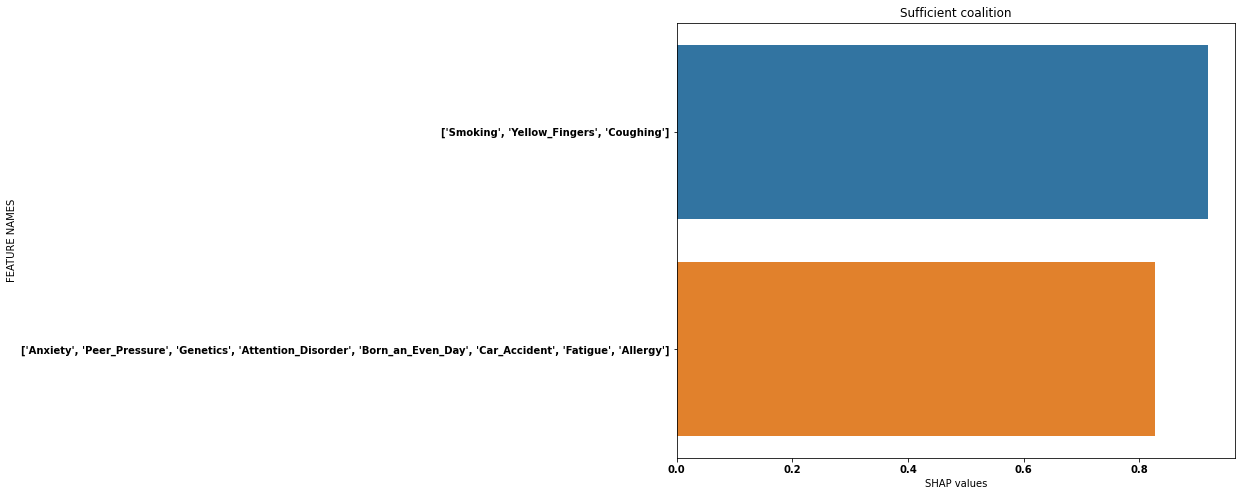

In [12]:
plt.rcParams["font.weight"] = "bold"
plot_feature_importance(sdp_importance_cluster, sdp_importance_name, 'forest_SDP  ', title='Sufficient coalition')

### Compute Shapley values based on $S^\star$ ?

In [13]:
from acv_explainers.utils import get_active_null_coalition_list

In [14]:
C = [[]]
sufficient_coal, bad_coal = get_active_null_coalition_list(sdp_index, size)

forest_sh_acv = acvtree.shap_values_acv(X=x, C=C, N_star=bad_coal[0], S_star=sufficient_coal[0])

<Figure size 1800x1200 with 0 Axes>

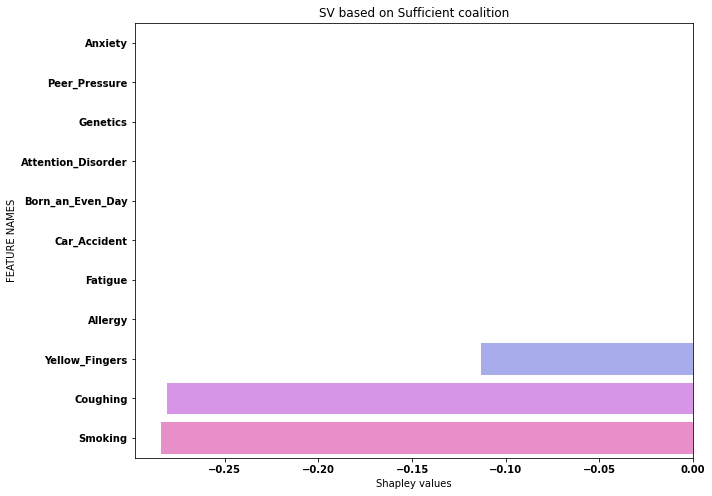

In [15]:
forest_shf_acv = np.mean(forest_sh_acv, 0)
forest_shf_acv = forest_shf_acv[:, 1]

plt.figure(dpi=300)
plot_feature_importance(forest_shf_acv, columns_names, 'shap value based on SDP Coalition ', 'Shapley values', title='SV based on Sufficient coalition')

### Compute ACV across all Data

We can compute Active SV by using the same $S^\star$ for all observations (using acvtree.shap_values_acv), or compute $S^\star$ for each observation and compute the Active SV by using the corresponding $S^\star$ for each observations (acvtree.shap_values_acv_adap). The second is much slower.

In [16]:
x = X[:50]

In [17]:
global_proba = 0.9

sdp_importance, sdp_index, size, sdp =\
acvtree.importance_sdp_clf(X=x, data=data, C=[[]], global_proba=global_proba, num_threads=10)

In [18]:
from acv_explainers.utils import get_null_coalition

s_star, n_star = get_null_coalition(sdp_index, size)

In [19]:
forest_sh_acv = acvtree.shap_values_acv_adap(X=x, C=C, N_star=n_star, size=size, S_star=s_star)

<Figure size 1800x1200 with 0 Axes>

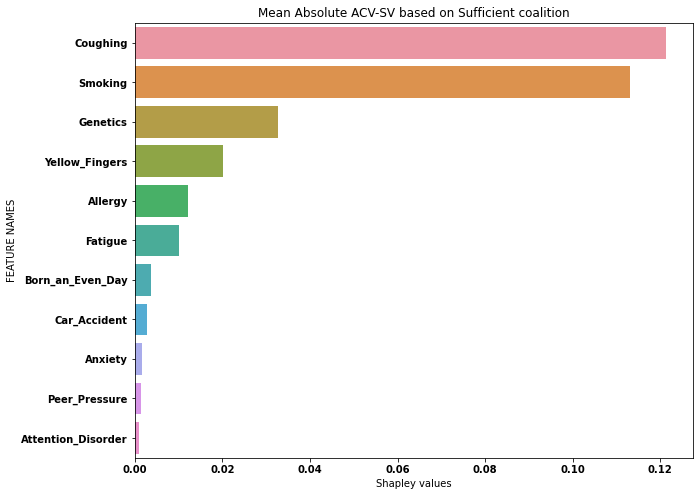

In [20]:
forest_shf_acv = np.mean(np.abs(forest_sh_acv), 0)
forest_shf_acv = forest_shf_acv[:, 1]

plt.figure(dpi=300)
plot_feature_importance(forest_shf_acv, columns_names, 'shap values based on SDP Coalition ', 'Shapley values', title='Mean Absolute ACV-SV based on Sufficient coalition')

### Global SDP when Y = 0 ? 

In [21]:
golbal_proba = 0.9
sdp_importance, sdp_index, size, sdp = \
acvtree.importance_sdp_clf(X=np.array(X_test.values[y_test<1], dtype=np.double),
                           data=np.array(X_train.values, dtype=np.double), C=[[]], 
                           global_proba=global_proba, num_threads=5)

<Figure size 1800x1200 with 0 Axes>

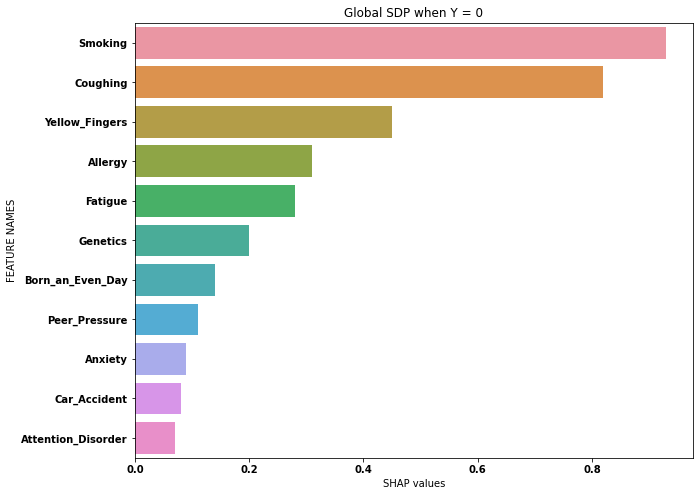

In [22]:
plt.figure(dpi=300)
plot_feature_importance(sdp_importance, columns_names, 'global sdp  ', title='Global SDP when Y = 0')

# 2- Demo regression: Linear GMM

##  How to compute SDP, $S^\star$, Shapley values based on $S^\star$ for regression model

##  Load data and model 

In [23]:
import random
random.seed(2021)

np.random.seed(2021)

In [24]:
from experiments.exp_linear_gmm import *

In [25]:
# p = 0.7
n = 20000
d = 5

for i in range(5):
    cov = {}
    gaus = np.random.randn(d, d)
    cov['a'] = np.dot(gaus, gaus.T)
    gaus = np.random.randn(d, d)
    cov['b'] = np.dot(gaus, gaus.T)
    gaus = np.random.randn(d, d)
    cov['c'] = np.dot(gaus, gaus.T)


    exp = ExperimentsLinearGMM(mean={'a': [0., 0., 0., 0., 0.], 'b': [0., 0., 0., 0., 0.], 'c': [0., 0., 0., 0., 0.]},
                               cov=cov,
                               coefs={'a': [9, 5, -8, 0, 0], 'b': [0, 0, -6, -8, -9], 'c': [4, 9, 13, 0, 0]},
                               pi={'a': 1/3, 'b': 1/3, 'c': 1/3}, n=n, C=[[5, 6]],
                               cat_index=[5, 6])

tree = DecisionTreeRegressor(min_samples_leaf=5, min_samples_split=10, max_depth=20, random_state=2021)
tree = exp.fit_model(tree)

fitted model train_error = 8.643123435721899
fitted model test_error = 26.323866305076756


In [26]:
seed = np.random.randint(0, 10000)
forest = RandomForestRegressor(n_estimators=1, min_samples_leaf=1, min_samples_split=2, max_depth=15, random_state=7706)
forest = exp.fit_model(forest)

forest.estimators_[0] = tree

fitted model train_error = 12.742500095967392
fitted model test_error = 33.55922150301721


In [27]:
idx = 156
ind = exp.data_test[idx]
y_ind = exp.y_test[idx]

fx = forest.predict(np.expand_dims(ind, 0))[0]

In [28]:
print('x = {}'.format(ind))

x = [ 2.0601348   2.00732006 -0.90904155 -1.91465107 -3.7068906   1.
  0.        ]


In [29]:
fx = forest.predict(np.expand_dims(ind, 0))[0]
print('f(x) = {}, y = {}'.format(fx, y_ind))

f(x) = 32.093696344810795, y = 35.85014586261256


In [30]:
print('----------------------TRAIN-------------------------------------------------------------------------------')
m, q9, q0 = ecart_model(tree, exp.data, exp.y_train)
print(' ')
print('----------------------TEST--------------------------------------------------------------------------------')
m, q9, q0 = ecart_model(tree, exp.data_test, exp.y_test)

----------------------TRAIN-------------------------------------------------------------------------------
mse = 8.643123435721899 -- max = 918.8833853473344 -- min = 6.993741382926936e-08 -- q0.95 = 34.79151162174746 -- q0.25 2.0150234355052072
 
----------------------TEST--------------------------------------------------------------------------------
mse = 26.323866305076756 -- max = 5395.2918251232295 -- min = 2.834571634473075e-08 -- q0.95 = 102.60694656786386 -- q0.25 6.5202158266233


# Build ACVTree for explanation

In [31]:
acvtree = ACVTree(forest, exp.data)

In [32]:
x = np.expand_dims(ind, 0)

### Compute SDP for all coalition $S \subset [0, \dots, d ]$ 

In [33]:
index = list(exp.index) + [[5, 6]]
s_index = len(index)
c_value = {i:{} for i in range(s_index + 1)}
i_best, c_best = {i: 100 for i in range(s_index + 1)}, {i: 100 for i in range(s_index + 1)}
data = exp.data
N = 10000

print('--------------- f_hat(ind) = {} ------------'.format(fx))
for size in tqdm(range(len(index) + 1)):
    for c in itertools.combinations(index, size):
        if len(c) != 0 and len(c) != len(index):
            
            value = acvtree.compute_sdp_reg(X=x, tX=10, S=np.array(chain_l(c), dtype=np.long), data=data)[0]
            
            if len(c) == 1:
                nam = 'X{}'.format(c[0]).replace('X[5, 6]', 'Y')
            elif len(c) == 2:
                nam = 'X{}, X{}'.format(c[0], c[1]).replace('X[5, 6]', 'Y')
            elif len(c) == 3:
                nam = 'X{}, X{}, X{}'.format(c[0], c[1], c[2]).replace('X[5, 6]', 'Y')
            elif len(c) == 4:
                nam = 'X{}, X{}, X{}, X{}'.format(c[0], c[1], c[2], c[3]).replace('X[5, 6]', 'Y')
            else:
                nam = 'X{}, X{}, X{}, X{}, X{}'.format(c[0], c[1], c[2], c[3], c[4]).replace('X[5, 6]', 'Y')
                
            c_value[size][nam] = value

  0%|          | 0/7 [00:00<?, ?it/s]

--------------- f_hat(ind) = 32.093696344810795 ------------


100%|██████████| 7/7 [00:36<00:00,  5.25s/it]


In [34]:
names = []
values = []
for size in c_value.keys():
    if size != 0:
        for part_name in c_value[size].keys():
            names.append(part_name)
            values.append(c_value[size][part_name])

def plot_feature_importance(importance, names, model_type, xlabel='SHAP values'):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
#     seaborn_colors = sns.color_palette("tab10")
#     colors = {names[i]: seaborn_colors[i] for i in range(len(names))}

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,20))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'], palette=sns.color_palette("husl", len(names)))
    #Add chart labels
    plt.title('SDP of every coalition')
    plt.xlabel(xlabel)
    plt.ylabel('FEATURE NAMES')
    plt.show()            

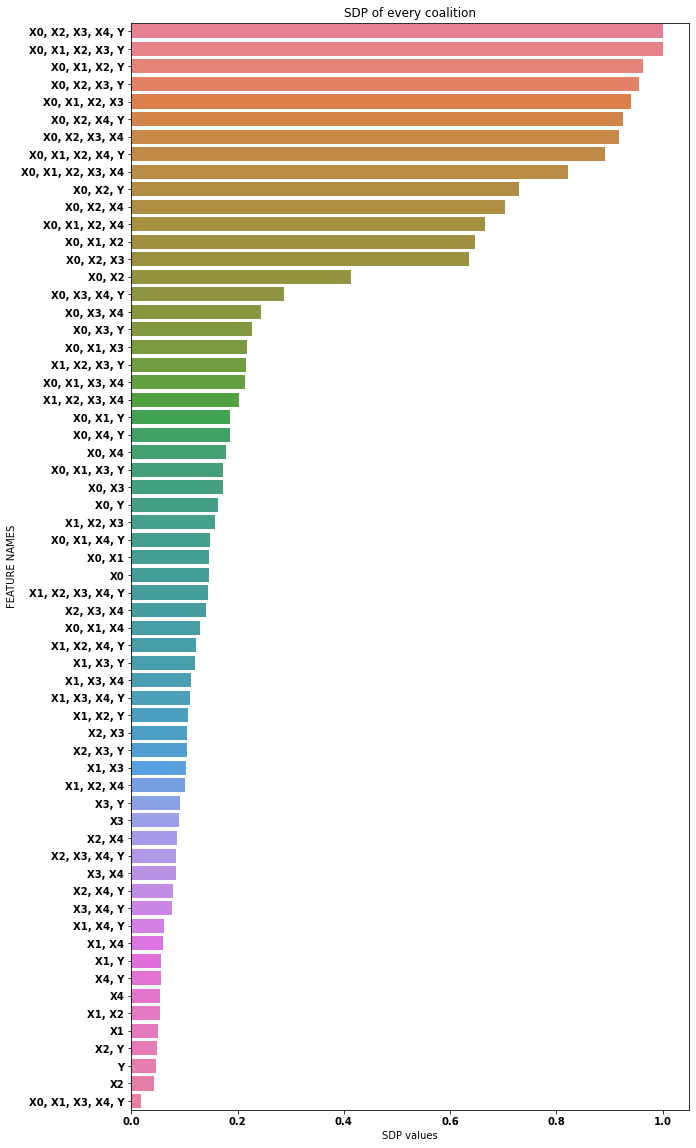

In [35]:
plot_feature_importance(values, names, 'forest_SDP  ', 'SDP values')

In [36]:
# plt.rcParams["font.weight"] = "bold"

def plot_feature_importance(importance, names, model_type, xlabel='SHAP values', title=''):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    seaborn_colors = sns.color_palette("tab10")
    colors = {names[i]: seaborn_colors[i] for i in range(len(names))}

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

    #Define size of bar plot
    plt.figure(dpi=100)
    #Plot Searborn bar chart
    sns.set(font_scale=1.5)
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'], palette=colors)
    #Add chart labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('FEATURE NAMES')

### Compute Classic Shapley values (by taking the coalition of dummy variables of categorical variable Y)

In [37]:
C = [[5, 6]] # indice of the dummy variables of Y

forest_sh = acvtree.shap_values(x, C=C)

print('SV = {}'.format(forest_sh))

SV = [[[12.01952106]
  [ 5.76584249]
  [-3.33645399]
  [15.04532589]
  [ 3.37753176]
  [-0.45676729]
  [-0.45676729]]]


<Figure size 1800x1200 with 0 Axes>

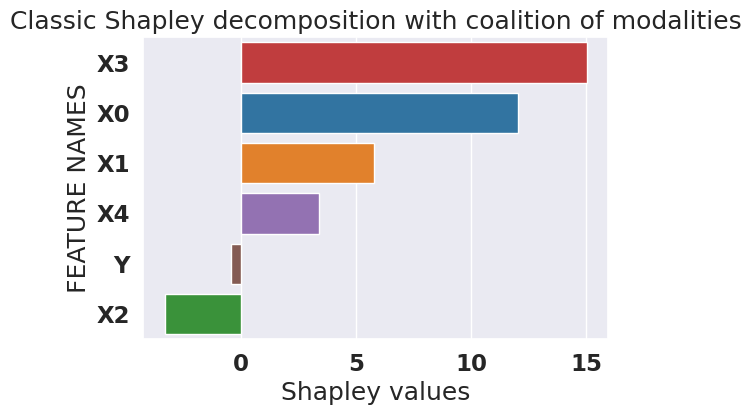

In [38]:
forest_shf = np.mean(forest_sh, 0)[:, 0]
columns_names = ['X0', 'X1', 'X2', 'X3', 'X4', 'Y']
forest_shf = forest_shf[:-1]

plt.figure(dpi=300)
plot_feature_importance(forest_shf, columns_names, 'Normal Shap values ', 'Shapley values', title='Classic Shapley decomposition with coalition of modalities')

### Now, let find the $S^\star$

In [39]:
threshold = 10
data = exp.data
global_proba = 0.9
    
sdp_importance, sdp_index, size, sdp = acvtree.importance_sdp_reg(X=x, tX=threshold,
                                                data=data, C=[[5, 6]], global_proba=global_proba, num_threads=5)


Cluster find by SDP = [0, 1, 2, 5, 6]


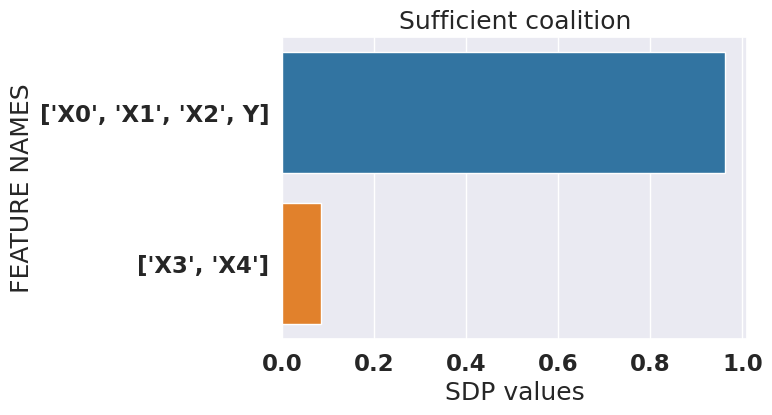

In [40]:

d = 7
index = list(range(d))

sdp_cluster = []
sdp_cluster = [[sdp_index[0, i] for i in range(size[0])]]
sdp_cluster += [list(set(index) - set(sdp_cluster[0]))]

print('Cluster find by SDP = {}'.format(sdp_cluster[0]))

sdp_importance_cluster = []
for c in sdp_cluster:     
    sdp_importance_cluster.append(acvtree.compute_sdp_reg(np.expand_dims(ind, 0), threshold, S=np.array(c), data=data))

sdp_importance_cluster = np.array(sdp_importance_cluster).reshape(-1)

sdp_importance_name = []
for c in sdp_cluster:
    sdp_importance_name.append(str(["X{}".format(i) for i in c]).replace("'X5', 'X6'", 'Y' ))

plot_feature_importance(sdp_importance_cluster, sdp_importance_name, model_type='forest SDP  ', xlabel='SDP values', title='Sufficient coalition')

### Since we know that the $S^\star$ is $X_0, X_1, X_2, Y$, we compute the SV based on Sufficient coalition

In [41]:
C = [[5, 6]]
S_star, N_star = get_active_null_coalition_list(sdp_index, size)

forest_sh_acv = acvtree.shap_values_acv(x, C=C, N_star=N_star[0], S_star=S_star[0])[:, :, 0]

In [42]:
forest_sh_acv

array([[ 9.91826372, 15.30435011,  2.15302211,  0.        ,  0.        ,
         5.03936398,  5.03936398]])

<Figure size 1800x1200 with 0 Axes>

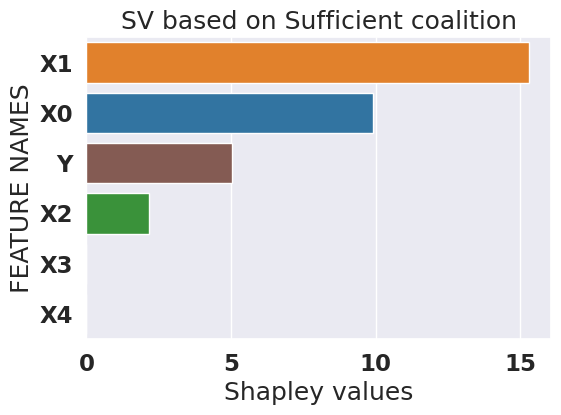

In [43]:
forest_shf_acv = np.mean(forest_sh_acv, 0)
columns_names = ['X0', 'X1', 'X2', 'X3', 'X4', 'Y']
forest_shf_acv = forest_shf_acv[:-1]

plt.figure(dpi=300)
plot_feature_importance(forest_shf_acv, columns_names, 'shap value based on SDP Coalition ', 'Shapley values', title='SV based on Sufficient coalition')

### Compute ACV across all Data

In [44]:
x = exp.data[:50]

In [45]:
global_proba = 0.9

sdp_importance, sdp_index, size, sdp =\
acvtree.importance_sdp_reg(X=x, data=data, tX=10, C=[[]], global_proba=global_proba, num_threads=10)

In [46]:
from acv_explainers.utils import get_null_coalition

s_star, n_star = get_null_coalition(sdp_index, size)

In [47]:
forest_sh_acv = acvtree.shap_values_acv_adap(X=x, C=C, N_star=n_star, size=size, S_star=s_star)

<Figure size 1800x1200 with 0 Axes>

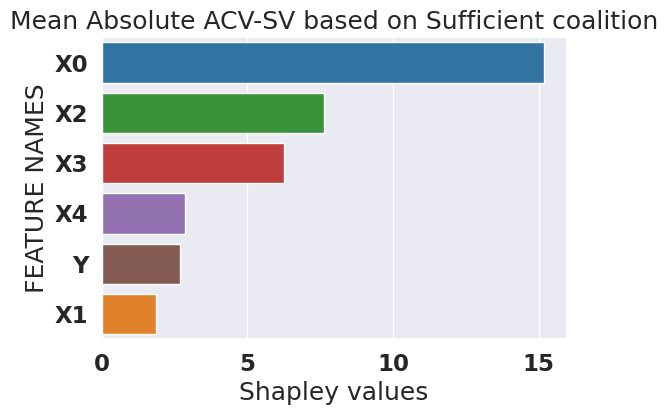

In [48]:
forest_shf_acv = np.mean(np.abs(forest_sh_acv), 0)
forest_shf_acv = forest_shf_acv.reshape(-1)[:-1]

plt.figure(dpi=300)
plot_feature_importance(forest_shf_acv, columns_names, 'shap values based on SDP Coalition ', 'Shapley values', title='Mean Absolute ACV-SV based on Sufficient coalition')